In [217]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, silhouette_score, confusion_matrix, adjusted_rand_score, adjusted_mutual_info_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# Importar el dataset
dataset = pd.read_csv("bike_sharing_for_hour_dataset.csv")

# Seleccionar las columnas de interés
# columns = ["weathersit", "windspeed", "atemp", "weathersit", "hum", "cnt", "instant", "weekday", "holiday", "mnth", "temp", "workingday", "hr", "season"]  # "casual", "registered",
#columns = ["windspeed", "hum", "cnt", "weekday", "mnth", "temp", "workingday", "season"]  # "casual", "registered",
columns = ['season','mnth','yr','weekday','holiday','workingday','weathersit','hum','temp','windspeed', 'cnt', 'instant', 'registered']
df = dataset[columns].copy()

labels = ['bajo', 'medio', 'alto']
df['label'] = pd.qcut(df['cnt'], q=3, labels=labels)

counts_label = df["label"].value_counts()
print(counts_label)

medio    5823
bajo     5797
alto     5759
Name: label, dtype: int64


In [89]:
df.describe()

,weathersit,atemp,windspeed,casual,registered,hum,cnt
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,1.425283,0.475775,0.190098,35.676218,153.786869,0.627229,189.463088
std,0.639357,0.171850,0.122340,49.305030,151.357286,0.192930,181.387599
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,1.000000,0.333300,0.104500,4.000000,34.000000,0.480000,40.000000
50%,1.000000,0.484800,0.194000,17.000000,115.000000,0.630000,142.000000
75%,2.000000,0.621200,0.253700,48.000000,220.000000,0.780000,281.000000
max,4.000000,1.000000,0.850700,367.000000,886.000000,1.000000,977.000000


In [125]:
#Tabla correlacional a HTML
df.corr()['cnt'].to_frame()


C:\Users\alejo\AppData\Local\Temp\ipykernel_36128\3130302367.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()['cnt'].to_frame()


,cnt
weathersit,-0.142426
atemp,0.400929
windspeed,0.093234
casual,0.694564
registered,0.972151
hum,-0.322911
cnt,1.000000


C:\Users\alejo\AppData\Local\Temp\ipykernel_36128\1037231913.py:23: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


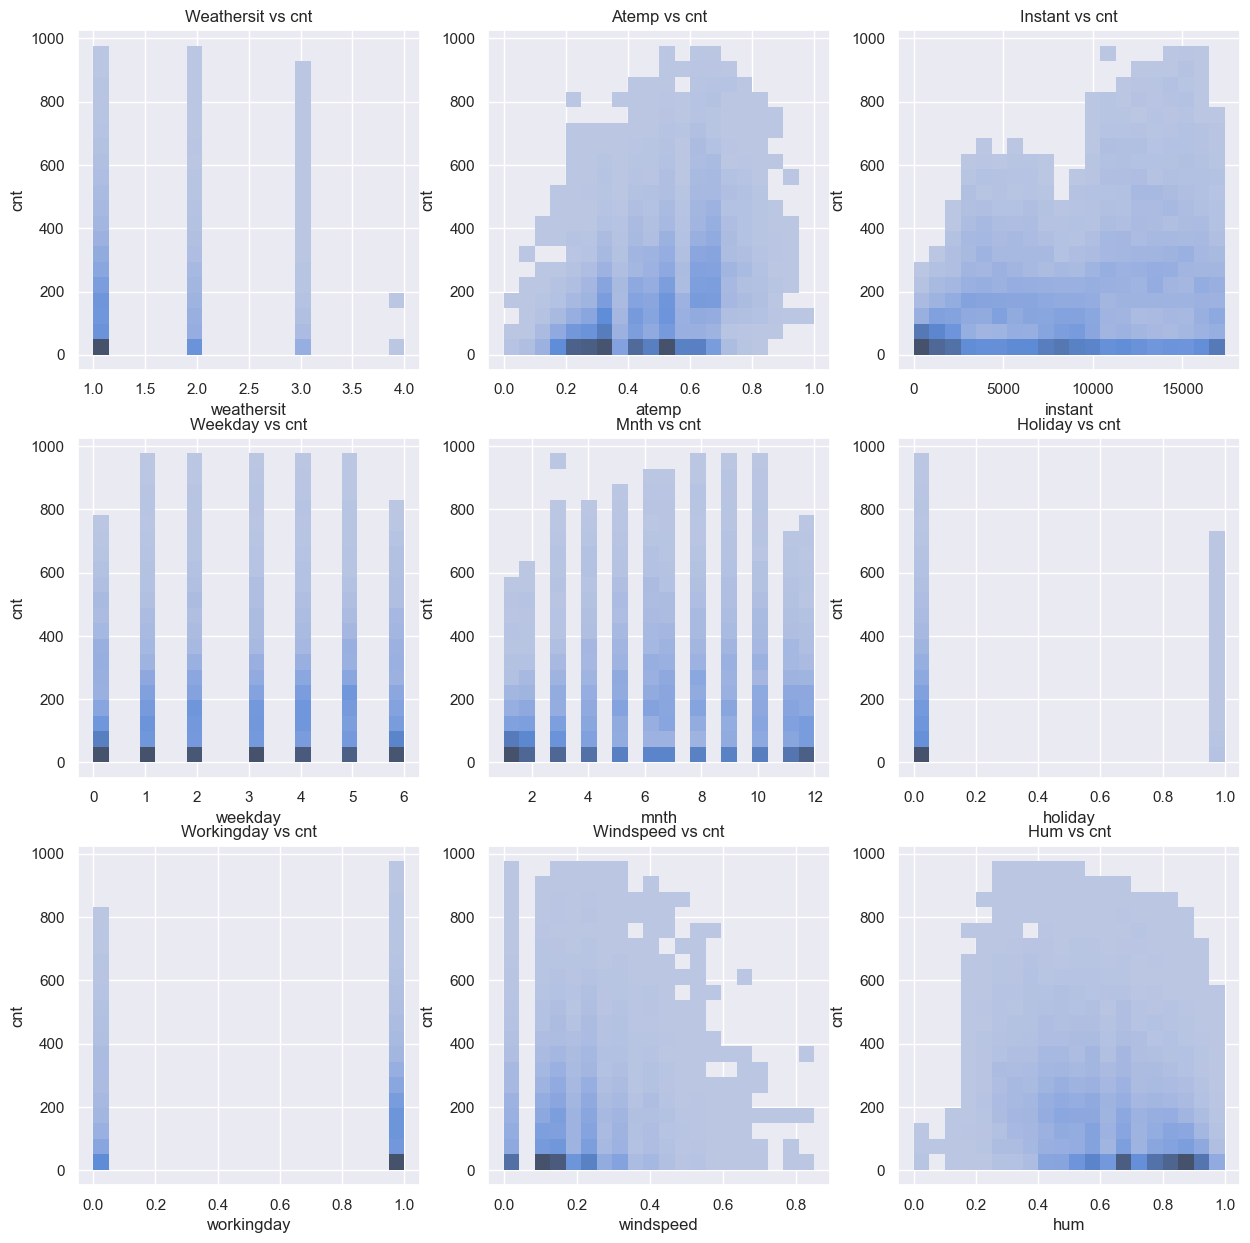

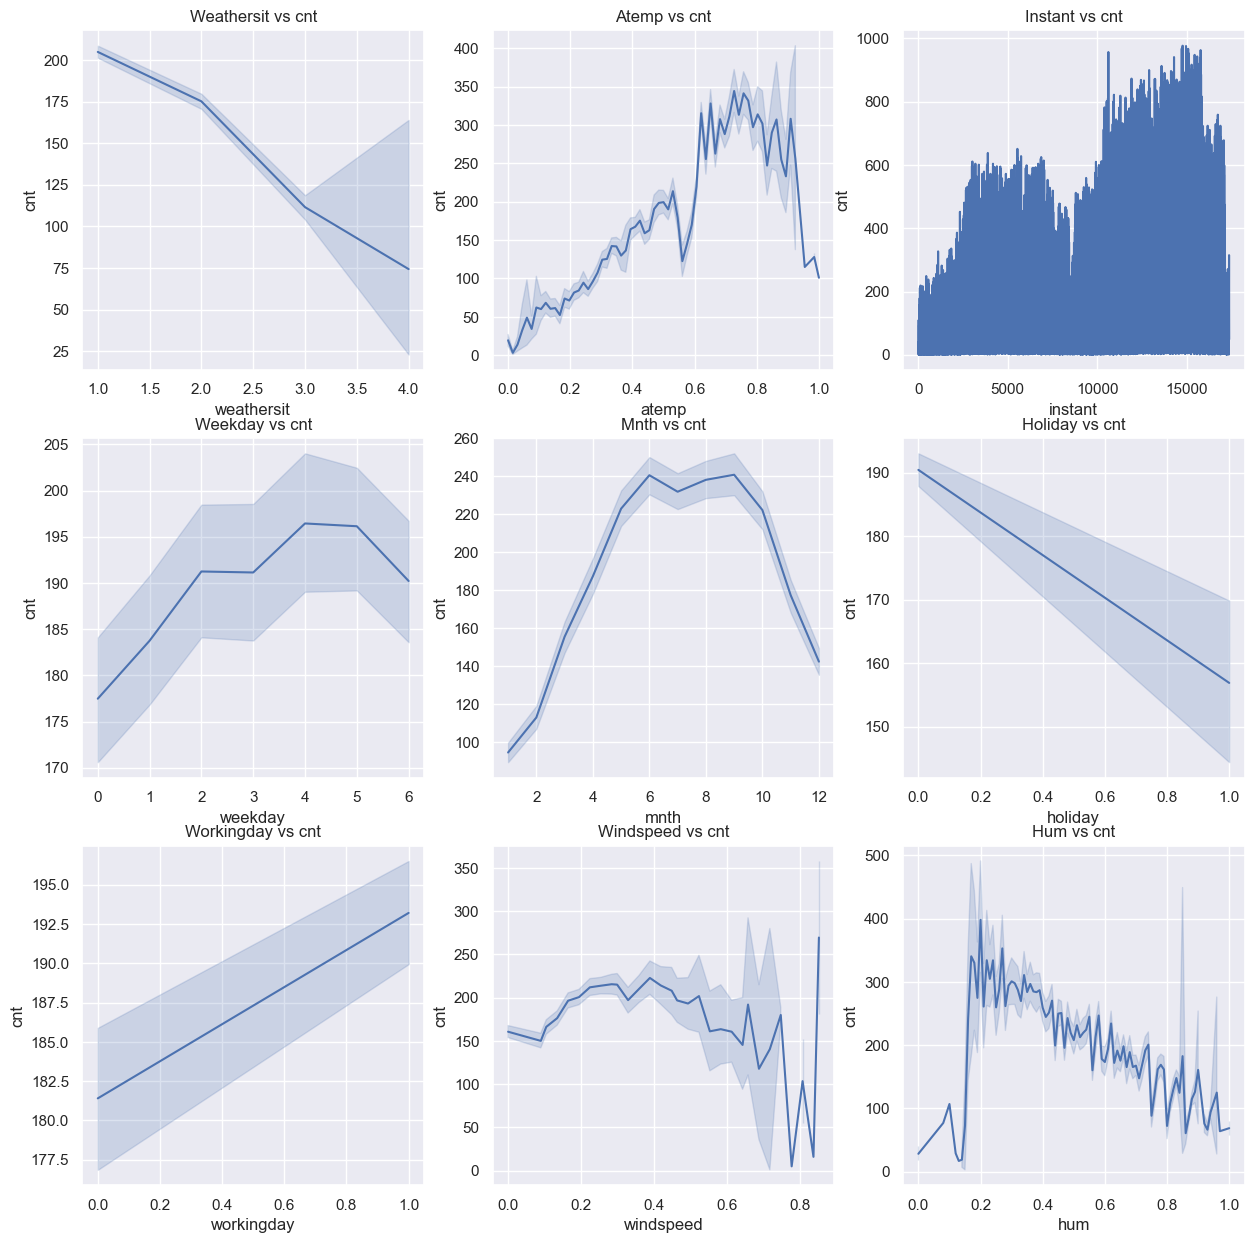

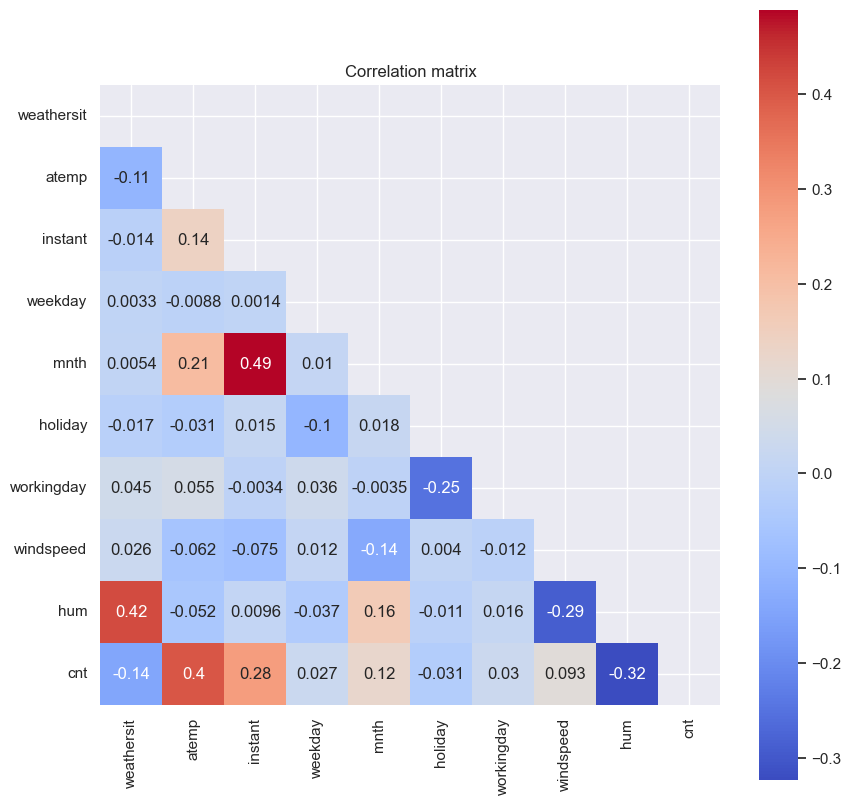

In [149]:
# crear figura y ejes para histogramas
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
axs = axs.ravel()

# crear histogramas y configurar cada uno
for i, col in enumerate(columns[:-1]):
    sns.histplot(data=df, x=col, y="cnt", ax=axs[i], bins=20)
    axs[i].set_title(f"{col.capitalize()} vs cnt")

# crear figura y ejes para plots
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
axs = axs.ravel()

# crear plots y configurar cada uno
for i, col in enumerate(columns[:-1]):
    sns.lineplot(data=df, x=col, y="cnt", ax=axs[i])
    axs[i].set_title(f"{col.capitalize()} vs cnt")

# crear figura y ejes para matriz de correlación
fig, ax = plt.subplots(figsize=(10, 10))

# crear matriz de correlación y configurar
corr_matrix = df.corr()
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap="coolwarm", square=True, ax=ax)
ax.set_title("Correlation matrix")

# mostrar todas las figuras
plt.show()

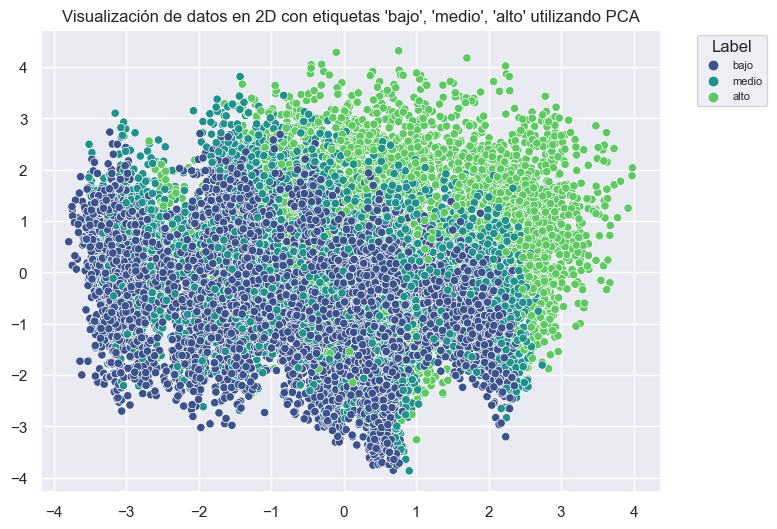

In [218]:
# Normalizar los datos
scaler = StandardScaler()
normalized_df = scaler.fit_transform(df.drop(columns=["label", "cnt"])) #group

# Aplicar PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(normalized_df)

# Crear un DataFrame con los resultados del PCA y las etiquetas
pca_df = pd.DataFrame(data=pca_result, columns=["Principal Component 1", "Principal Component 2"])
pca_df["label"] = df["label"]

# Visualizar los datos en un gráfico 2D utilizando PCA
plt.figure(figsize=(8, 6))
scatter = sns.scatterplot(x=pca_df["Principal Component 1"], y=pca_df["Principal Component 2"], hue=pca_df["label"], palette="viridis", legend="full")
plt.legend(title="Label", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.gca().set_xlabel('')
plt.gca().set_ylabel('')
plt.title("Visualización de datos en 2D con etiquetas 'bajo', 'medio', 'alto' utilizando PCA")
plt.show()

In [219]:
# Aprendizaje supervisado

# Definir las variables dependientes e independientes
y = df["cnt"]
X = normalized_df

# Dividir el conjunto de datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y entrenar el modelo de regresión lineal
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predecir valores usando el conjunto de prueba
y_pred = lr.predict(X_test)

# Calcular el error cuadrático medio y el coeficiente de determinación (R^2)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Realizar la validación cruzada con k=5
scores = cross_val_score(lr, X_train, y_train, cv=5)

print("Error cuadrático medio: ", mse)
print("Coeficiente de determinación (R^2): ", r2)
# Imprimir las puntuaciones y su media
print("Puntuaciones de la validación cruzada: ", scores)
print("Puntuación media de la validación cruzada: ", scores.mean())

Error cuadrático medio:  1066.2163640891433
Coeficiente de determinación (R^2):  0.9663286747561811
Puntuaciones de la validación cruzada:  [0.96206965 0.96514109 0.96757853 0.96676971 0.96651294]
Puntuación media de la validación cruzada:  0.9656143840088658


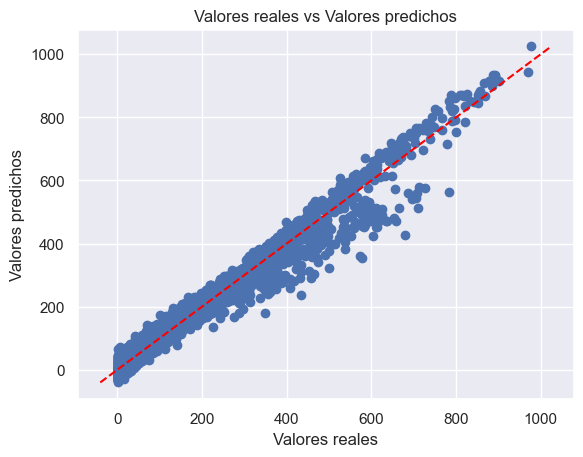

In [220]:
# Crear un gráfico de dispersión
plt.scatter(y_test, y_pred)
plt.xlabel('Valores reales')
plt.ylabel('Valores predichos')

# Crear una línea que represente una predicción perfecta (y_test = y_pred)
min_value = min(min(y_test), min(y_pred))
max_value = max(max(y_test), max(y_pred))
plt.plot([min_value, max_value], [min_value, max_value], color='red', linestyle='--')

plt.title('Valores reales vs Valores predichos')
plt.show()

In [153]:
df_without_labeling = df.drop(["cnt", "label"], axis=1)

# Normalizar los datos
normalized_df = (df_without_labeling - df_without_labeling.min()) / (df_without_labeling.max() - df_without_labeling.min())

# Estandarizamos los datos
# scaler = StandardScaler()
# normalized_df = pd.DataFrame(normalized_df, columns=df_without_labeling.columns)

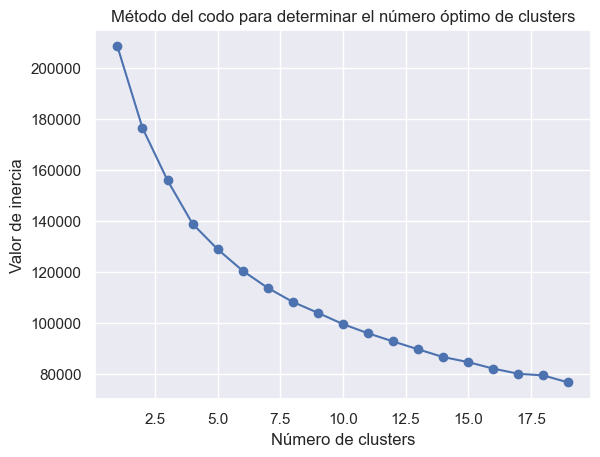

In [221]:
# Determinar el número óptimo de clusters utilizando el método del codo (elbow method)
inertia_values = []
num_clusters = range(1, 20)

for k in num_clusters:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(normalized_df)
    inertia_values.append(kmeans.inertia_)

plt.plot(num_clusters, inertia_values, "o-")
plt.xlabel("Número de clusters")
plt.ylabel("Valor de inercia")
plt.title("Método del codo para determinar el número óptimo de clusters")
plt.show()

In [108]:
# Función para proyectar matrices de confusión y evaluar el clustering de los modelos aplicados

def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=False):
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('Etiqueta verdadera')
    plt.xlabel('Etiqueta predicha')
    plt.show()

In [109]:
# Función para proyectar los clusteres sin PCA
def plot_clusters(normalized_df, clusters):
    plt.figure(figsize=(8, 6))
    scatter = sns.scatterplot(x=normalized_df.iloc[:, 0], y=normalized_df.iloc[:, 1], hue=clusters, palette="viridis", legend="full")
    plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    #plt.xlabel("Número de bicicletas prestadas (normalizado)")
    #plt.ylabel("Factores de predicción (normalizado)")
    plt.title("Visualización de clusters en 2D")
    plt.show()

In [110]:
# Función para proyectar los clusteres con PCA
def plot_clusters_pca(pca_result, clusters):
    plt.figure(figsize=(8, 6))
    scatter = sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=clusters, palette="viridis", legend="full")
    plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    #plt.xlabel("Componente de número de bicicletas prestadas")
    #plt.ylabel("Componente de factores de predicción")
    plt.title("Visualización de clusters en 2D utilizando PCA")
    plt.show()

In [143]:
# Aprendizaje no supervisado sin usar reducción de dimensionalidad usando PCA

# Entrenar el modelo K-Means con 3 clústeres
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
clusters = kmeans.fit_predict(normalized_df)

# Visualizar los clusters en un gráfico 2D
plot_clusters(normalized_df, clusters)

# Crear un DataFrame con las etiquetas de los clusters
clustered_df = normalized_df.copy()
clustered_df["Cluster"] = clusters

# Analizar los resultados numéricamente
cluster_counts = clustered_df["Cluster"].value_counts()
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Calcular el coeficiente de silueta
silhouette_avg = silhouette_score(normalized_df, clusters)
print("Coeficiente de silueta promedio:", silhouette_avg)

# Calcular la inercia
inertia = kmeans.inertia_
print("Inercia:", inertia)

# Evaluando el modelo 
clustered_df["label"] = df["label"]

# Convertir las etiquetas "Bajo", "Medio" y "Alto" a números enteros para que puedan ser comparadas con las etiquetas de clustering
label_mapping = {"bajo": 2, "medio": 1, "alto": 0}
true_labels = clustered_df["label"].map(label_mapping)

# Calcular la matriz de confusión
conf_mat = confusion_matrix(true_labels, clusters)
plot_confusion_matrix(conf_mat, target_names=["Bajo", "Medio", "Alto"], normalize=True)

# Calcular el índice ARI
ari = adjusted_rand_score(true_labels, clusters)
print("Índice ARI:", ari)

# Calcular el índice AMI
ami = adjusted_mutual_info_score(true_labels, clusters)
print("Índice AMI:", ami)

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

<Figure size 800x600 with 0 Axes>

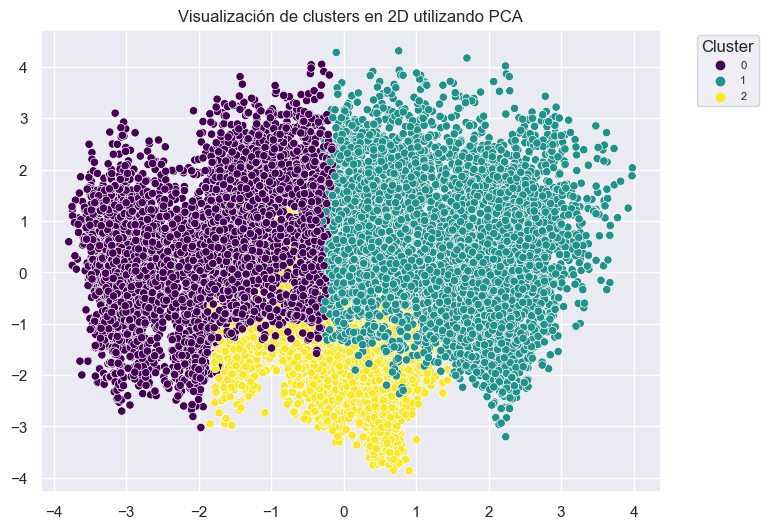

Coeficiente de silueta promedio: 0.1578985263482551
Inercia: 155923.79722478567


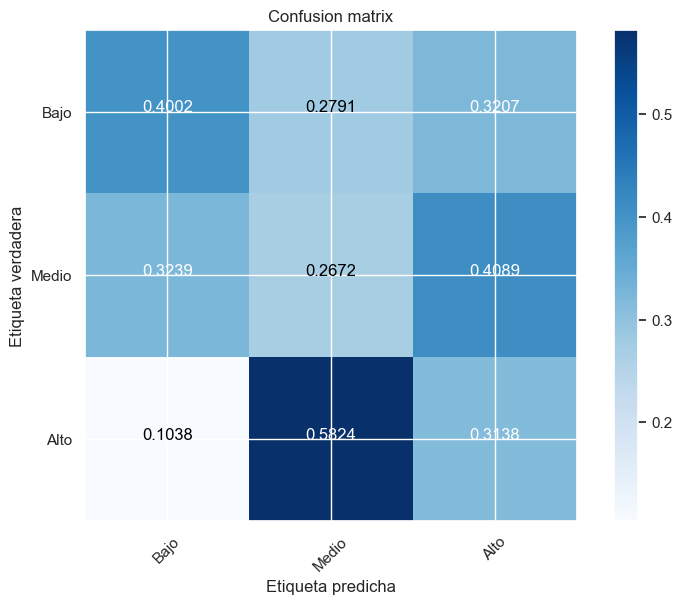

Índice ARI: 0.057601179163110965
Índice AMI: 0.056575554584956195


In [222]:
# Aprendizaje no supervisado

# Entrenar el modelo K-Means con 3 clústeres
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
clusters = kmeans.fit_predict(normalized_df)

# Realizar reducción de dimensionalidad utilizando PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(normalized_df)

# Visualizar los clusters en un gráfico 2D
plot_clusters_pca(pca_result, clusters)

# Crear un DataFrame con los resultados del PCA y las etiquetas de los clusters
principal_components_df = pd.DataFrame(data=pca_result, columns=["Principal Component 1", "Principal Component 2"])
principal_components_df["Cluster"] = clusters

# Analizar los resultados numéricamente
cluster_counts = principal_components_df["Cluster"].value_counts()
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Calcular el coeficiente de silueta
silhouette_avg = silhouette_score(normalized_df, clusters)
print("Coeficiente de silueta promedio:", silhouette_avg)

# Calcular la inercia
inertia = kmeans.inertia_
print("Inercia:", inertia)


#Evaluando el modelo 
principal_components_df["label"] = df["label"]

# Convertir las etiquetas "Bajo", "Medio" y "Alto" a números enteros para que puedan ser comparadas con las etiquetas de clustering
label_mapping = {"bajo": 0, "medio": 1, "alto": 2}
true_labels = principal_components_df["label"].map(label_mapping)

# Calcular la matriz de confusión
conf_mat = confusion_matrix(true_labels, clusters)
plot_confusion_matrix(conf_mat, target_names=["Bajo", "Medio", "Alto"], normalize=True)

# Calcular el índice ARI
ari = adjusted_rand_score(true_labels, clusters)
print("Índice ARI:", ari)

# Calcular el índice AMI
ami = adjusted_mutual_info_score(true_labels, clusters)
print("Índice AMI:", ami)


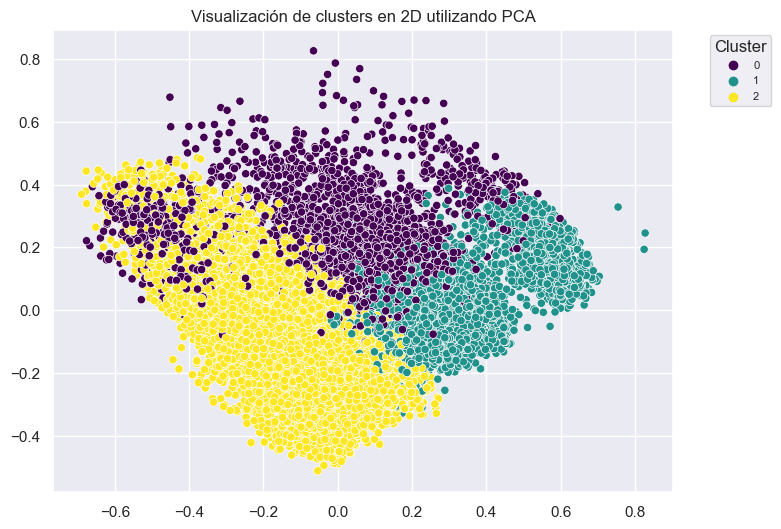

Coeficiente de silueta promedio: 0.20660360215354315


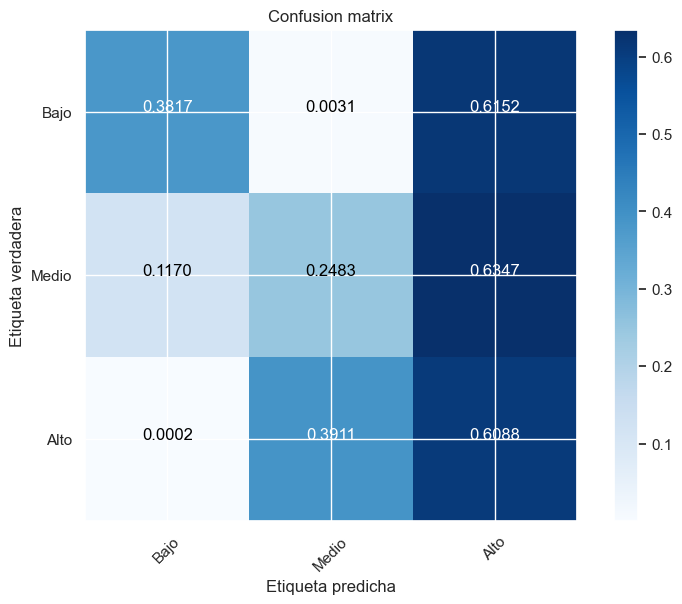

Índice ARI: 0.06993647467453629
Índice AMI: 0.175372691124638


In [117]:
### Gaussian Mixture clustering

# Entrenar el modelo Gaussian Mixture Model con 2 clústeres
gmm = GaussianMixture(n_components=3, random_state=42)
clusters = gmm.fit_predict(normalized_df)

# Realizar reducción de dimensionalidad utilizando PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(normalized_df)

# Visualizar los clusters en un gráfico 2D
plot_clusters_pca(pca_result, clusters)

# Crear un DataFrame con los resultados del PCA y las etiquetas de los clusters
principal_components_df = pd.DataFrame(data=pca_result, columns=["Principal Component 1", "Principal Component 2"])
principal_components_df["Cluster"] = clusters

# Analizar los resultados numéricamente
cluster_counts = principal_components_df["Cluster"].value_counts()
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Calcular el coeficiente de silueta
silhouette_avg = silhouette_score(normalized_df, clusters)
print("Coeficiente de silueta promedio:", silhouette_avg)

# Calcular la inercia
# La inercia no está disponible para GMM, así que la omitimos

# Evaluando el modelo
principal_components_df["label"] = df["label"]

# Convertir las etiquetas "Bajo", "Medio" y "Alto" a números enteros para que puedan ser comparadas con las etiquetas de clustering
label_mapping = {"bajo": 2, "medio": 1, "alto": 0}
true_labels = principal_components_df["label"].map(label_mapping)

# Calcular la matriz de confusión
conf_mat = confusion_matrix(true_labels, clusters)
plot_confusion_matrix(conf_mat, target_names=["Bajo", "Medio", "Alto"], normalize=True)

# Calcular el índice ARI
ari = adjusted_rand_score(true_labels, clusters)
print("Índice ARI:", ari)

# Calcular el índice AMI
ami = adjusted_mutual_info_score(true_labels, clusters)
print("Índice AMI:", ami)

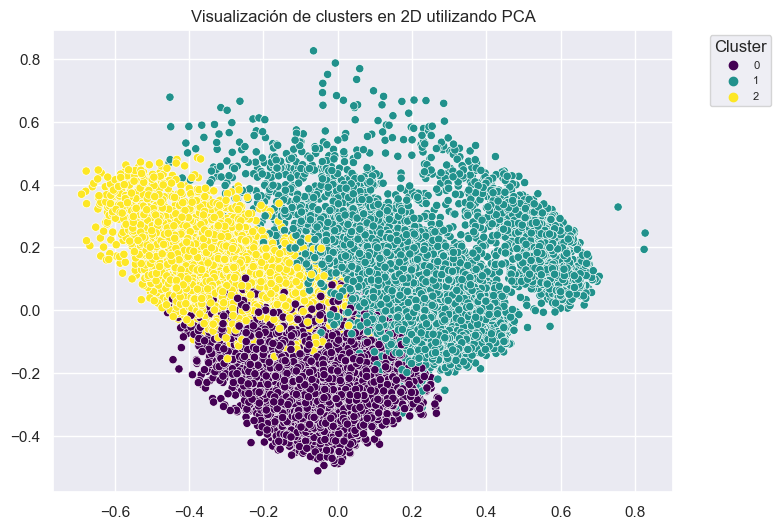

Coeficiente de sileta promedio: 0.22438393315359587
Matriz de confusión:



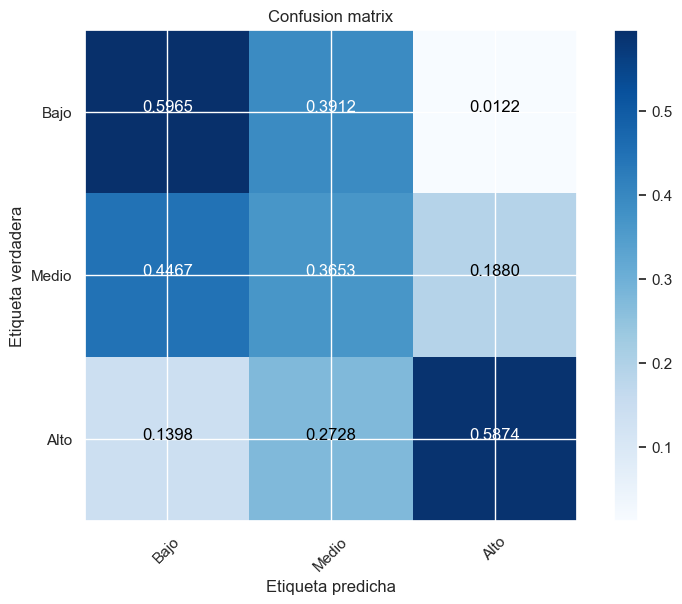

Índice ARI: 0.14327633130851167
Índice AMI: 0.1650085156798964


In [119]:
### Ward clustering

# Entrenar el modelo de Clustering Jerárquico de Ward con 2 clústeres
ward = AgglomerativeClustering(n_clusters=3, linkage='ward')
clusters = ward.fit_predict(normalized_df)

# Realizar reducción de dimensionalidad utilizando PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(normalized_df)

# Visualizar los clusters en un gráfico 2D
plot_clusters_pca(pca_result, clusters)

# Crear un DataFrame con los resultados del PCA y las etiquetas de los clusters
principal_components_df = pd.DataFrame(data=pca_result, columns=["Principal Component 1", "Principal Component 2"])
principal_components_df["Cluster"] = clusters

# Analizar los resultados numéricamente
cluster_counts = principal_components_df["Cluster"].value_counts()
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Calcular el coeficiente de silueta
silhouette_avg = silhouette_score(normalized_df, clusters)
print("Coeficiente de sileta promedio:", silhouette_avg)

# La inercia no está disponible para el Clustering Jerárquico, así que la omitimos

# Evaluando el modelo
principal_components_df["label"] = df["label"]

# Convertir las etiquetas "Bajo", "Medio" y "Alto" a números enteros para que puedan ser comparadas con las etiquetas de clustering
label_mapping = {"bajo": 0, "medio": 1, "alto": 2}
true_labels = principal_components_df["label"].map(label_mapping)

# Calcular la matriz de confusión
print("Matriz de confusión:\n")
conf_mat = confusion_matrix(true_labels, clusters)
plot_confusion_matrix(conf_mat, target_names=["Bajo", "Medio", "Alto"], normalize=True)


# Calcular el índice ARI
ari = adjusted_rand_score(true_labels, clusters)
print("Índice ARI:", ari)

# Calcular el índice AMI
ami = adjusted_mutual_info_score(true_labels, clusters)
print("Índice AMI:", ami)

# Dibujar el dendrograma
# plt.figure(figsize=(8, 6))
# linked = linkage(normalized_df, method='ward')
# dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
# plt.title("Dendrograma del Clustering Jerárquico de Ward")
# plt.xlabel("Índice del caso")
# plt.ylabel("Distancia")
# plt.show()

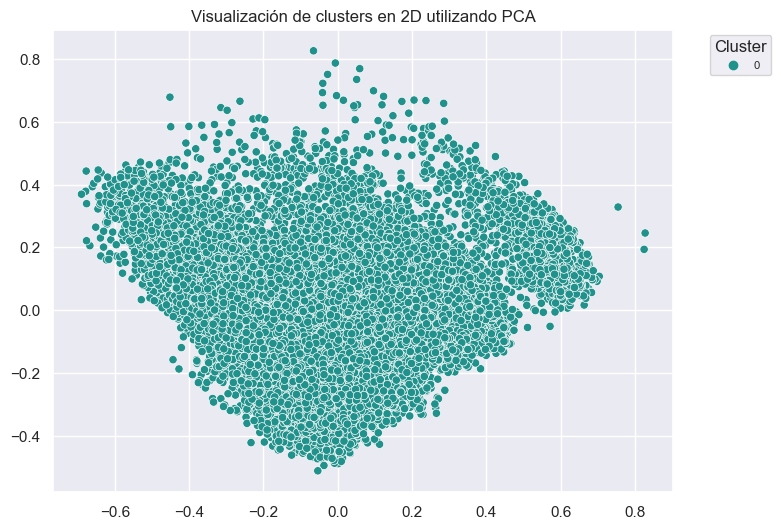

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [120]:
# Aprendizaje no supervisado

# Importar MeanShift
from sklearn.cluster import MeanShift
from sklearn.cluster import estimate_bandwidth

# Estimar el ancho de banda óptimo para que encuentre los clusteres
bandwidth = estimate_bandwidth(normalized_df, quantile=0.3)

# Entrenar el modelo Mean Shift con el ancho de banda ajustado
mean_shift = MeanShift(bandwidth=bandwidth)
clusters = mean_shift.fit_predict(normalized_df)

# Realizar reducción de dimensionalidad utilizando PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(normalized_df)

# Visualizar los clusters en un gráfico 2D
plot_clusters_pca(pca_result, clusters)

# Crear un DataFrame con los resultados del PCA y las etiquetas de los clusters
principal_components_df = pd.DataFrame(data=pca_result, columns=["Principal Component 1", "Principal Component 2"])
principal_components_df["Cluster"] = clusters

# Analizar los resultados numéricamente
cluster_counts = principal_components_df["Cluster"].value_counts()
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
#print("Número de puntos por cluster:\n", cluster_counts)

# Calcular el coeficiente de silueta
silhouette_avg = silhouette_score(normalized_df, clusters)
print("Coeficiente de silueta promedio:", silhouette_avg)

# La inercia no está disponible para Mean Shift, así que la omitimos

# Evaluando el modelo
principal_components_df["label"] = df["label"]

# Convertir las etiquetas "Bajo", "Medio" y "Alto" a números enteros para que puedan ser comparadas con las etiquetas de clustering
label_mapping = {"bajo": 0, "medio": 1, "alto": 2}
true_labels = true_labels = principal_components_df["label"].map(label_mapping)

# Calcular la matriz de confusión
conf_mat = confusion_matrix(true_labels, clusters)
plot_confusion_matrix(conf_mat, target_names=["Bajo", "Medio", "Alto"], normalize=True)
#print("Matriz de confusión:\n", conf_mat)

# Calcular el índice ARI
ari = adjusted_rand_score(true_labels, clusters)
print("Índice ARI:", ari)

# Calcular el índice AMI
ami = adjusted_mutual_info_score(true_labels, clusters)
print("Índice AMI:", ami)